# Sample splitting, grid search, and regression

"*If you torture the data long enough, it will confess.*" — Ronald Coase

***


### Complexity control

Recall that **one of the most important fundamental principles underlying data science, the basis for machine learning, is *complexity control***.  We must manage the tension between allowing ourselves to fit complex patterns in the data (a good thing), and the tendency to fit idiosyncracies in a particular data set--things that do not generalize (a bad thing).  So, we attempt to control complexity.  One way to control complexity is just not to allow our data mining procedure to fit complex models in the first place.  That's what we do when we build linear models from small sets of features.  But let's consider the case where we think larger feature sets or non-linearities might add important predictive power--so we will attempt to control complexity in a data-driven fashion.

We will be using the bike data from the Pedal Bikeshare case study.

In [1]:
import pandas as pd

df = pd.read_csv("bike-day.csv")
df.head(5)

,instant,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,count,abovecap
0,1,1,1,0,0,0,1,0.370000,0.692500,0.192167,2294,0
1,2,1,1,1,1,0,1,0.273043,0.381304,0.329665,1951,0
2,3,1,1,0,2,1,1,0.150000,0.441250,0.365671,2236,0
3,4,1,1,0,3,1,2,0.107500,0.414583,0.184700,2368,0
4,5,1,1,0,4,1,1,0.265833,0.524167,0.129987,3272,0


Suppose we want to predict the daily bike demand given the specific characteristics of each day. This would be a regression problem.

In [2]:
# Set up feature data
feature_names = ['season', 'mnth', 'holiday', 'weekday', 'weathersit', 'temp', 'hum', 'windspeed']
categorical_features = ['season', 'mnth', 'weekday', 'weathersit']
X = pd.get_dummies(df[feature_names], columns=categorical_features)

# Set up target variable
y = df["count"]

## Sample splitting

Let's now re-explore the modeling technique we used in the last lab session -- tree-structured models. And since our target is to predict a numeric value (rather than a category or a binary value), let's consider a `DecisionTreeRegressor`.

For the following illustrations, we will manipulate complexity with the hyper-parameter `min_samples_leaf`, which represents the minimum number of observations that tree leaves can have. So, the lower the value for `min_samples_leaf`, the larger the tree can grow, and so the more complex the model will be. We will also evaluate the performance of the resulting models using mean squared error.

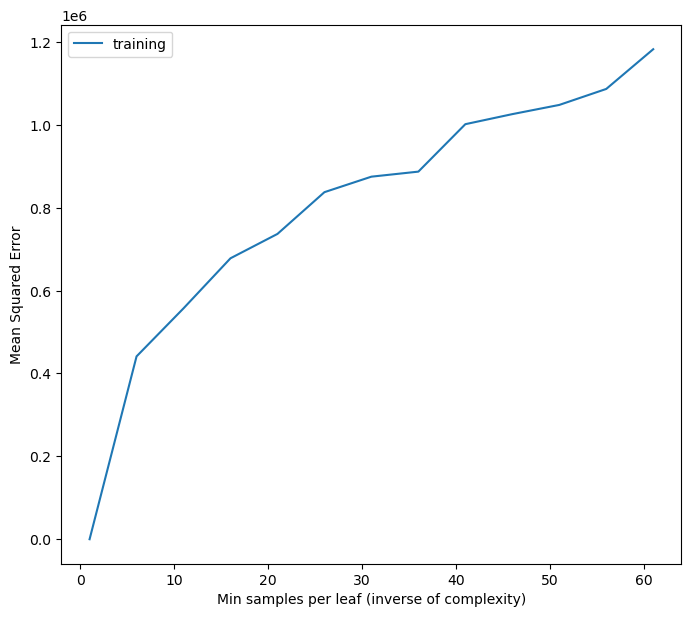

In [3]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 7

# Function to plot the results
def plot_fitting_curves(results):
    results.plot("min_leaves")
    plt.ylabel("Mean Squared Error")
    plt.xlabel("Min samples per leaf (inverse of complexity)")
    plt.show()
    
# Evaluate model performance with different degrees of complexity
min_leaves = range(1,66, 5)
errors = []
for m in min_leaves:
    model = DecisionTreeRegressor(min_samples_leaf=m, random_state=42)
    model.fit(X, y)
    predictions = model.predict(X)
    mse = ((y - predictions)**2).mean()
    errors.append(mse)
    
results = pd.DataFrame({"min_leaves": min_leaves, "training": errors})
plot_fitting_curves(results)

The chart shows that the more we allow the tree to grow (i.e., the more complex the model is), the lower the model's error. That's because higher complexity allows models to capture more complex patterns in the data. However, note that in this chart **the same data is being used to train and evaluate the models, which is a BIG NO-NO in data science**. This is a concern because machine learning algorithms may overfit to the training data, meaning that the complex patterns found by the models may not generalize outside the training data.

For this reason, models should be evaluated using a separate sample from the one that was used to train them. The code below shows how this can be easily done using the `train_test_split` function in the `sklearn.model_selection` library. 

In [4]:
from sklearn.model_selection import train_test_split

# The command below splits X and y into a training set and a test set.
# There are two other important paramaters we included in this function.
# -test_size: The fraction of the data kept in the test set (or the # of obs. in the test set if an integer is used)
# -random_state: Random seed to ensures that the split is always the same (which is useful to reproduce results)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Size of training data: {X_train.shape[0]}")
print(f"Size of test data: {X_test.shape[0]}")

Size of training data: 292
Size of test data: 74


Now, let's take a look at what happens when we evaluate the models using the test set.

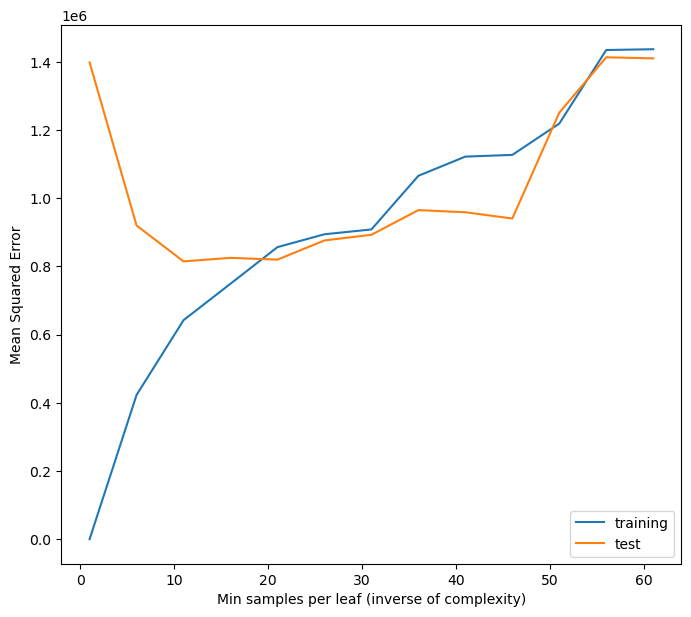

In [5]:
errors_train = []
errors_test = []
for m in min_leaves:
    model = DecisionTreeRegressor(min_samples_leaf=m, random_state=42)
    model.fit(X_train, y_train)
    # Evaluation in the same data used to train the model
    predictions_train = model.predict(X_train)
    mse_train = ((y_train - predictions_train)**2).mean()
    errors_train.append(mse_train)
    # Evaluation in previously unseen data
    predictions_test = model.predict(X_test)
    mse_test = ((y_test - predictions_test)**2).mean()
    errors_test.append(mse_test)
    
results = pd.DataFrame({"min_leaves": min_leaves, "training": errors_train, "test":errors_test})
plot_fitting_curves(results)

Complexity can help capture more complex patterns, but more complexity is not necessarily better. Too much complexity will result in overfitting, and too little complexity will result in underfitting. So, we should search for the optimal degree of complexity by evaluating and comparing models using data that is different from the training set. This chart suggests that the optimal complexity is between `min_samples_leaf=10` and `min_samples_leaf=20`.

However, keep in mind that **you may also be overfitting while searching for the optimal complexity**! If you are using the same sample to evaluate models with all sorts of degrees of complexity, one of them may work particularly well just by chance. Essentially, you are trying out so many different things that something ought to work, but that doesn't mean you will see the same performance in a different sample. Check out [this comic](https://imgs.xkcd.com/comics/significant.png) for an example of what I mean.

So, in practice, you DO NOT want to use the test set to compare different models. Instad, the purpose of the test set is to evaluate the generalization performance of whatever model you chose before deploying it.

What, then, can we do to find the optimal degree of complexity? We will illustrate two alteratives below.

## Option 1: Validation set

The first alternative is quite straightforward. Just split the training set once again into a sub-training set (used to build models) and a validation set (used to compare the out-of-sample performance of models with different degrees of complexity). 

<img src="validation.png">

For this, we can use exactly the same code as in the cells above.

Size of sub-training data: 233
Size of validation data: 59


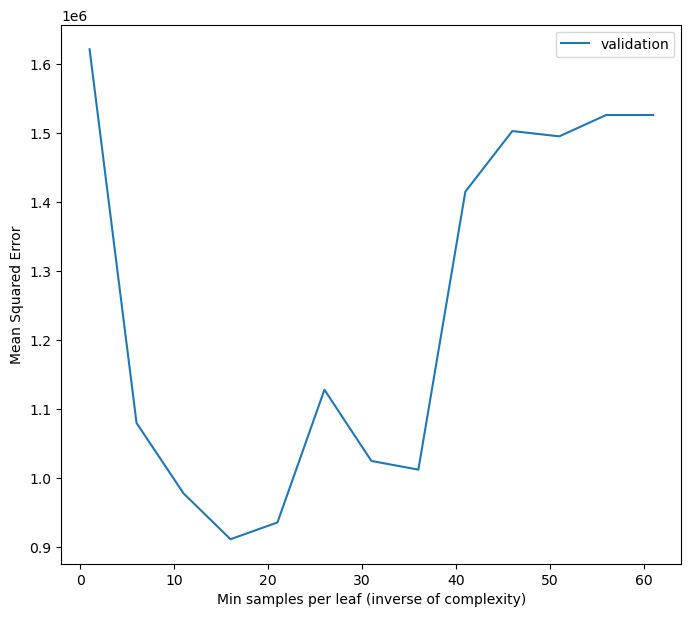

In [6]:
# Split into a sub training set and validation set
X_strain, X_val, y_strain, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(f"Size of sub-training data: {X_strain.shape[0]}")
print(f"Size of validation data: {X_val.shape[0]}")

errors_val = []
for m in min_leaves:
    # We train the model with only a portion of the training data (the 'sub-training' data set)
    model = DecisionTreeRegressor(min_samples_leaf=m, random_state=42)
    model.fit(X_strain, y_strain)
    predictions_val = model.predict(X_val)
    # And we evaluate in the validation set
    mse_val = ((y_val - predictions_val)**2).mean()
    errors_val.append(mse_val)

results = pd.DataFrame({"min_leaves": min_leaves, "validation":errors_val})
plot_fitting_curves(results)

This chart suggests that the optimal degree of complexity is `min_samples_leaf=16`.

## Option 2: Cross-validation

Above, we made a single train/validation split. We set aside 20% of our data and never used it for training. We also never used the 80% of the data set aside for training to test generalizability. Although this is far better than testing on the training data, which does not measure generalization performance at all, there are two potential problems with the simple holdout approach.

1) Perhaps the random split was particularly bad (or good). Do we have any confidence in our accuracy estimate? We are using only 20% of the data for validation. Could we possibly use the data more fully for testing?

2) Often we want to know something about the distribution of our evaluation metrics. A simple train/test split only allows a single "point estimate"

So, instead of only making a single split, let's use cross-validation so that every record contributes to validation as well as training (as shown in the image below). For more details about cross-validation, read Chapter 5 of the book. 

<img src="cross-validation.png">

Modifying the code above to use cross-validation is straighforward. We just need to replace the code lines for fitting the model and making predictions with the function `cross_val_predict`, which provides the cross-validation (out-of-sample) predictions of each observation in the training set.

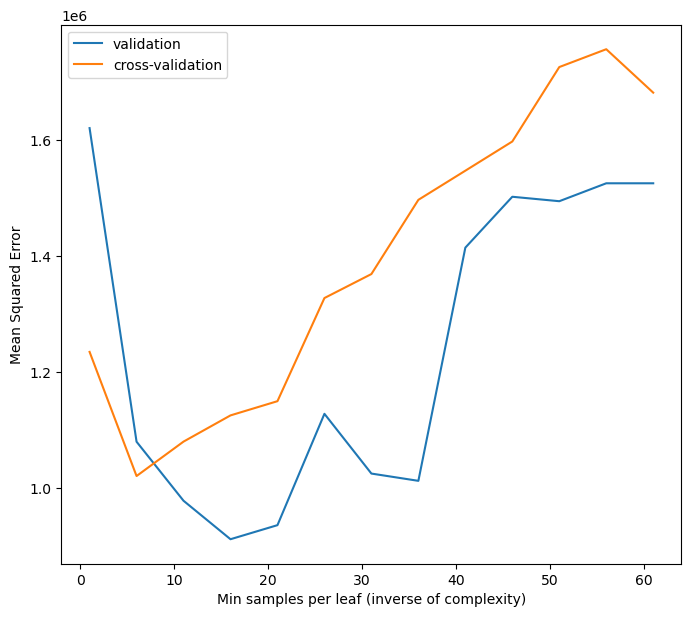

In [7]:
from sklearn.model_selection import cross_val_predict

errors_cv = []
for m in min_leaves:
    # Define hyperparamter for complexity control
    algorithm = DecisionTreeRegressor(min_samples_leaf=m, random_state=42)
    # Evaluate the performance of the hyperparameter with cross validation. 
    # The parameter 'cv' is used to determine the number of splits (folds). 
    predictions_cv = cross_val_predict(algorithm, X_train, y_train, cv=5)
    mse_cv = ((y_train - predictions_cv)**2).mean()
    errors_cv.append(mse_cv)

results = pd.DataFrame({"min_leaves": min_leaves, "validation":errors_val, "cross-validation":errors_cv})
plot_fitting_curves(results)

Interestingly, cross-validation suggests that we should use a more complex model than we initially thought. Thus, this example shows that cross-validation can lead to better model tuning by taking more advantage of the available data.

## Grid search

The concept explored above can be extended in a very natural way to simultaniuosly optimize many hyper-parameters using a technique called "grid search". The technique consists of first defining a "grid" of hyper-parameter values to explore. Then, a grid search algorithm explores all possible combinations of hyperparameters, selecting the combination with the best cross-validated value for the chosen performance measure (mean squared error in our case).

This can be easily achieved using the `GridSearchCV` function, as shown in the code below.



In [9]:
from sklearn.model_selection import GridSearchCV

# Define the parameterse to try out, the algorithm, and the number of folds
tree_grid = {"min_samples_leaf":min_leaves, "criterion":['squared_error', 'absolute_error', 'friedman_mse']}
tree_algorithm = DecisionTreeRegressor(random_state=42)
tree_searcher = GridSearchCV(tree_algorithm, tree_grid, cv=5, scoring="neg_mean_squared_error")

# Search the best combination of parameters
tree_searcher.fit(X_train, y_train)

# Print the parameters that led to the best out-of-sample performance
print(f"Best parameters: {tree_searcher.best_params_}")
print(f"Best score (negative MSE): {tree_searcher.best_score_}")

Best parameters: {'criterion': 'squared_error', 'min_samples_leaf': 6}
Best score (negative MSE): -1018403.0893854955


GridSearchCV can also be used to find the parameters that lead to the best performance according to some custom-made function (e.g., profits). For instance, suppose that we want to measure error in absolute (rather than squared) terms, and that underestimations of bike demand are three times more expensive than overestimations. Below there is an example of how to find the best model parameters to maximize such a performance measure.

In [10]:
from sklearn.metrics import make_scorer

# Define custom loss/error function
def my_custom_error_func(y_true, y_pred):
    error_cost = np.abs(y_true - y_pred) * (1 + 2 * (y_true > y_pred))
    return error_cost.mean()

# Create a scorer for that function
scorer = make_scorer(my_custom_error_func, greater_is_better=False)
tree_searcher = GridSearchCV(tree_algorithm, tree_grid, cv=5, scoring=scorer)

# Search the best combination of parameters and report the results
tree_searcher.fit(X_train, y_train)
print(f"Best parameters: {tree_searcher.best_params_}")
print(f"Best score (negative custom error): {tree_searcher.best_score_}")

Best parameters: {'criterion': 'absolute_error', 'min_samples_leaf': 11}
Best score (negative custom error): -1400.4114552893045


## Comparing multiple algorithms

The code above can easily be extended to consider more algorithms beyond decision trees. For example, we could also consider Ridge and Lasso regression. For an illustration, check the code below.

In [11]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Define parameters for linear algorithms
lin_grid = {"alpha": [10**i for i in np.arange(-1, 2, 0.1)]}
ridge_algorithm = Ridge()
lasso_algorithm = Lasso()

# Conduct grid searches
tree_searcher = GridSearchCV(tree_algorithm, tree_grid, cv=5, scoring=scorer)
ridge_searcher = GridSearchCV(ridge_algorithm, lin_grid, cv=5, scoring=scorer)
lasso_searcher = GridSearchCV(lasso_algorithm, lin_grid, cv=5, scoring=scorer)

for searcher in [tree_searcher, ridge_searcher, lasso_searcher]:
    searcher.fit(X_train, y_train)
    print(f"Algorithm : {type(searcher.best_estimator_)}")
    print(f"Best parameters: {searcher.best_params_}")
    print(f"Best score (negative custom error): {searcher.best_score_}")
    print("--------")

Algorithm : <class 'sklearn.tree._classes.DecisionTreeRegressor'>
Best parameters: {'criterion': 'absolute_error', 'min_samples_leaf': 11}
Best score (negative custom error): -1400.4114552893045
--------
Algorithm : <class 'sklearn.linear_model._ridge.Ridge'>
Best parameters: {'alpha': 0.9999999999999994}
Best score (negative custom error): -1346.3808563700363
--------
Algorithm : <class 'sklearn.linear_model._coordinate_descent.Lasso'>
Best parameters: {'alpha': 5.01187233627272}
Best score (negative custom error): -1343.5218453689263
--------


Out of all the algorithms (and their different parameter combinations), the above suggests that the best we could use is a Lasso regression with `alpha=5.01` 

## Evaluating the selected model

Once we have finally selected a model for deployment, we are ready to test its performance in the test set. For that, we only need to ask the grid searcher to give us the `best_estimator_`, which is the model that resulted from using the entire training data and the best combination of hyper-parameters.

Error in the test set: 1624.194352113902


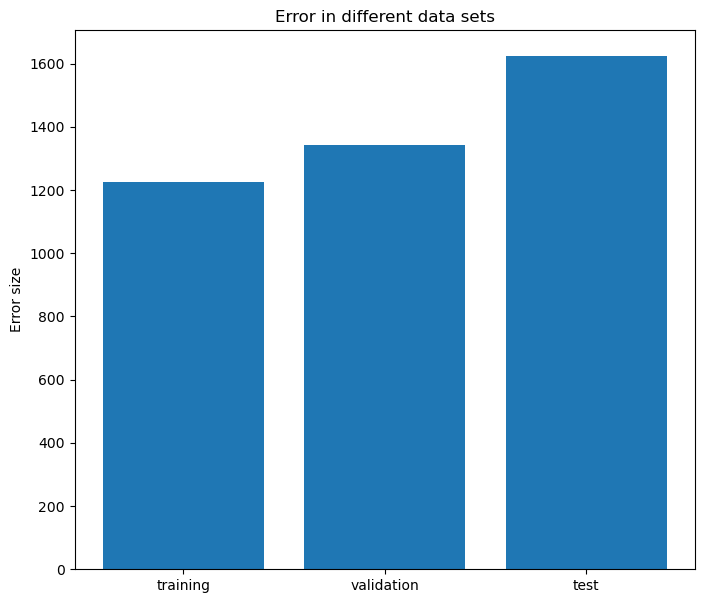

In [12]:
# Choose final model
final_model = lasso_searcher.best_estimator_

# Evaluate on the test set
test_predictions = final_model.predict(X_test)
test_error = my_custom_error_func(y_test, test_predictions)
print(f"Error in the test set: {test_error}")

###### Here are the evaluations on the validation sets and the training set as baseline comparisons
# Evaluate using out-of-sample predictions on the data used to tune the model
cv_predictions = cross_val_predict(final_model, X_train, y_train, cv=5)
cv_error = my_custom_error_func(y_train, cv_predictions)
# Evaluate using the data used to build the model
train_predictions = final_model.predict(X_train)
train_error = my_custom_error_func(y_train, train_predictions)

# Plot results
plt.bar(['training', 'validation', 'test'], [train_error, cv_error, test_error])
plt.title("Error in different data sets")
plt.ylabel("Error size")
plt.show()

Not surprisingly, the error in the test set is significantly larger than in the validation sets (used to tune the model) and the training set (used to build the model).